This is a reduced version of https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import numpy as np

In this notebook, we classify names by their origin country. The task at hand is the following: Given an input sequence `input`. e.g. `["K", "o", "t", "t", "m", "a", "n", "n"]`, define a neural network that approximates $p(\text{country of origin} | \text{input})$. We provide training data consisting of examples for `n_categories` $= 18$ different countries, so the output dimension of the neural network is `n_categories`. More details on this later.

Here, we use a letter-based approach, which means we have the following correspondences  
  * word $\sim$ letter
  * sentence $\sim$ word

So now an input sequence `["K", "o", "t", "t", "m", "a", "n", "n"]` is on a character-level and our "vocabulary" is all the letters `abc..ABC..` + special characters `<space>.,:;'`  
The following code block defines the vocabulary, reads in the data and processes it so we can use it (this is rather technical and should not be our main focus)

In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/Scottish.txt', 'data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Portuguese.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Vietnamese.txt', 'data/names/Irish.txt']
Slusarski


`category_lines` is now a dictionary containing languages as keywords, and a list of all names from data as keys

In [3]:
print(category_lines["Polish"])

['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz', 'Bernard', 'Bobienski', 'Bosko', 'Broz', 'Brzezicki', 'Budny', 'Bukoski', 'Bukowski', 'Chlebek', 'Chmiel', 'Czajka', 'Czajkowski', 'Dubanowski', 'Dubicki', 'Dunajski', 'Dziedzic', 'Fabian', 'Filipek', 'Filipowski', 'Gajos', 'Gniewek', 'Gomolka', 'Gomulka', 'Gorecki', 'Gorka', 'Gorski', 'Grzeskiewicz', 'Gwozdek', 'Jagoda', 'Janda', 'Janowski', 'Jaskolski', 'Jaskulski', 'Jedynak', 'Jelen', 'Jez', 'Jordan', 'Kaczka', 'Kaluza', 'Kaminski', 'Kasprzak', 'Kava', 'Kedzierski', 'Kijek', 'Klimek', 'Kosmatka', 'Kowalczyk', 'Kowalski', 'Koziol', 'Kozlow', 'Kozlowski', 'Krakowski', 'Krol', 'Kumiega', 'Lawniczak', 'Lis', 'Majewski', 'Malinowski', 'Maly', 'Marek', 'Marszaek', 'Maslanka', 'Mencher', 'Miazga', 'Michel', 'Mikolajczak', 'Mozdzierz', 'Niemczyk', 'Niemec', 'Nosek', 'Nowak', 'Pakulski', 'Pasternack', 'Pasternak', 'Paszek', 'Piatek', 'Piontek', 'Pokorny', 'Poplawski', 'Rog', 'Rudaski', 'Rudawski', 'Rusnak', 'Rutkowski', 'Sadowski

In [4]:
print(category_lines.keys())

dict_keys(['Polish', 'Czech', 'Japanese', 'Scottish', 'French', 'Chinese', 'Portuguese', 'Arabic', 'German', 'Greek', 'Russian', 'Italian', 'Spanish', 'English', 'Dutch', 'Korean', 'Vietnamese', 'Irish'])


We now have to transform letters to vectors. We use a one-hot-encoding for that, giving each letter a unique vector. This is the most simple choice of an Embedding and brings many disavantages. Yet, it is sufficient for this example.

In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [6]:
len(all_letters) # this is our vocabulary size

57

A sequence `Jones` is then transformed to a sequence of $57-$dimensional vectors.

In [7]:
lineToTensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

 Note the second dimension is the batch_size, which for this example is just 1.

In [8]:
lineToTensor('Jones').shape

torch.Size([5, 1, 57])

We now write a very simple `RNN` module that simply concatenates the `input` and previous `hidden` vector and linearly processes them

In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # i2h = input to hidden - standard definitions for creating recurrent modules (I guess?)
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # i2o = input to out
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Note that here we are performing a classification task, so the output dimension of the RNN should be put to the number of categories.

In [10]:
input0 = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input0, hidden)

In [11]:
print(output)

tensor([[-2.8856, -2.9056, -2.8053, -2.8622, -2.7920, -2.9512, -2.8236, -2.8995,
         -2.9312, -3.0281, -2.8834, -2.8122, -2.8199, -2.9160, -2.8760, -3.0111,
         -2.9806, -2.8836]], grad_fn=<LogSoftmaxBackward>)


Note that this is a very simple implementation and does not have the sequential processing like the predefined torch RNN modules we have seen in the previous notebook. So inputting a sequence does not work. We have to implement the sequential character by hand for the evaluation and training later. Of course, it is advised / much easier to use the predefined `torch.nn.RNN`, `torch.nn.LSTM` and `torch.nn.GRU` modules.

In [12]:
input0 = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input0, hidden)
# dimensionality error, this rnn implementation is NOT built like torch.nn.RNN!

RuntimeError: torch.cat(): Tensors must have same number of dimensions: got 3 and 2

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 4)


In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, "line tensor size: ", line_tensor.shape)

category = English / line = Albutt line tensor size:  torch.Size([6, 1, 57])
category = Irish / line = Riain line tensor size:  torch.Size([5, 1, 57])
category = Korean / line = Tsai  line tensor size:  torch.Size([5, 1, 57])
category = English / line = Radford line tensor size:  torch.Size([7, 1, 57])
category = Czech / line = Timpe line tensor size:  torch.Size([5, 1, 57])
category = Irish / line = Rinn line tensor size:  torch.Size([4, 1, 57])
category = Spanish / line = Santos line tensor size:  torch.Size([6, 1, 57])
category = Spanish / line = Azarola line tensor size:  torch.Size([7, 1, 57])
category = Chinese / line = Kuang line tensor size:  torch.Size([5, 1, 57])
category = Korean / line = Suh line tensor size:  torch.Size([3, 1, 57])


Note that the `RNN` can process names of different sizes. In this notebook sequences are called lines.

### Loss function
We use the negative log-likelihood loss  
Note that it is important to use a softmax at the output layer of the RNN such that they are normalized to mimic probabilities.

In [15]:
loss_fn = nn.NLLLoss()

### Training step
We can use the torch functionalities to obtain the gradient with `loss.backward()` (his is quite a low-level implementation).

In [16]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    # Sequential processing "by hand"
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = loss_fn(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

### Training loop

In [17]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.7178 Trinh / Chinese ✗ (Vietnamese)
10000 10% (0m 11s) 2.7443 Naggia / Japanese ✗ (Italian)
15000 15% (0m 16s) 1.4538 Milligan / Irish ✓
20000 20% (0m 22s) 2.3258 Pokorny / Czech ✗ (Polish)
25000 25% (0m 28s) 2.2736 Asker / German ✗ (Arabic)
30000 30% (0m 33s) 0.0658 Emelianenkov / Russian ✓
35000 35% (0m 39s) 0.2290 Duong / Vietnamese ✓
40000 40% (0m 44s) 0.7452 Piatek / Polish ✓
45000 45% (0m 50s) 0.1876 Huynh / Vietnamese ✓
50000 50% (0m 56s) 1.2142 Watson / English ✗ (Scottish)
55000 55% (1m 1s) 0.5120 Ta / Vietnamese ✓
60000 60% (1m 7s) 1.9090 Bradan / Arabic ✗ (Irish)
65000 65% (1m 13s) 2.2460 Crane / French ✗ (English)
70000 70% (1m 18s) 0.6811 Dreher / German ✓
75000 75% (1m 24s) 1.3488 Schuhart / Dutch ✗ (German)
80000 80% (1m 30s) 2.0596 Chukhray / Arabic ✗ (Russian)
85000 85% (1m 35s) 3.3495 Charron / Irish ✗ (French)
90000 90% (1m 41s) 0.8952 Choe / Korean ✓
95000 95% (1m 47s) 3.1128 Sessa / Czech ✗ (Italian)
100000 100% (1m 52s) 2.1511 Newcombe / German ✗

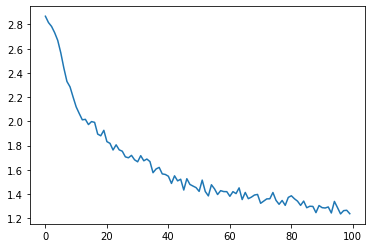

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

We can now test the performance of the trained network

In [19]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [20]:
def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = np.exp(topv[0][i].item()) #transforming logits to probabilities
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Kottmann')


> Dovesky
(0.81) Russian
(0.14) Czech
(0.02) Polish
(0.02) English
(0.00) French

> Jackson
(0.58) Scottish
(0.18) English
(0.14) Russian
(0.02) Korean
(0.02) Czech

> Kottmann
(0.54) Scottish
(0.22) German
(0.09) English
(0.04) Japanese
(0.02) Chinese


A more thorough analysis includes calculating the confusion matrix

`<unk>`, `<pad>`, `<bos>`, `<eos>`

`tokenize(["Hello", "my", "name", "is", "Korbinian", "who", "are", "you"])`  
`>> [<bos>, 3, 45, 23, 14, <unk>, 23, 66, 90, <eos>, <pad>, <pad>, ...]`

<ipython-input-21-f26d6365eead>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-21-f26d6365eead>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


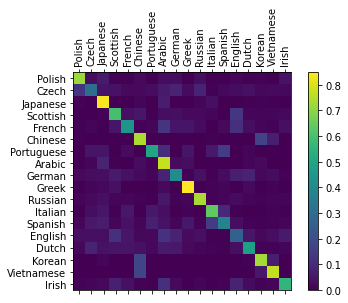

In [21]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Quite surprisingly (to me at least), this very simple model is doing very well at predicting the country of origin of family names!